In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch 
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
!pip install scikit-image

In [5]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [6]:
torch.cuda.is_available()

False

In [7]:
def generate_gaussian_maps(keypoints, shape, sigma=0.1):
    # keypoints: B x K x 2
    # shape: H x W
    yy, xx = torch.meshgrid(
        torch.linspace(1, -1, shape[-2]),
        torch.linspace(-1, 1, shape[-1]),
    )
    m = torch.exp(- 0.5 * ((xx[None, None, :, :] - keypoints[:, :, None, None, 0]) ** 2 + (yy[None, None, :, :] - keypoints[:, :, None, None, 1]) ** 2) / sigma ** 2)
    return m

    plt.imshow(generate_gaussian_maps())

In [8]:
def gaussian_heatmap(image_size, center, sigma):
    """Creates a heatmap image with size `image_size` and a gaussian blob with `sigma` at `center`.

    coord frame is origin topleft and u right, v down.
    Args:
        image_size: tuple with image dimensions (width, height)
        center: tuple with center coordinate (cx, cy)
        sigma: float
    Returns:
        heatmap: (w, h) heatmap image

    """
    
    u_axis = torch.linspace(0, image_size[0]-1, image_size[0]) - center[0]
    v_axis = torch.linspace(0, image_size[1]-1, image_size[1]) - center[1]
    # create grid values in 2D with x and y coordinate centered aroud the keypoint 
    xx, yy = torch.meshgrid(v_axis, u_axis) 

    ## create gaussian around the centered 2D grids $ exp ( -0.5 (x**2 + y**2) / sigma**2)$
    heatmap = torch.exp(-0.5 * (torch.square(xx) + torch.square(yy)) / torch.square(sigma))
    return heatmap

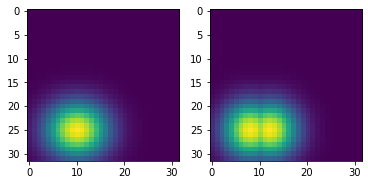

In [9]:
## Demonstration on why one should use max(.) instead of sum to combine the keypoints
# sum wil make 1 blob of 2 neighbouring keypoints
# furthermore it will also reduce the 
img = gaussian_heatmap((32,32),(8,25),torch.Tensor([4]))
img2 = gaussian_heatmap((32,32),(12,25),torch.Tensor([4]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img  +img2)
axarr[1].imshow(torch.max(img, img2))

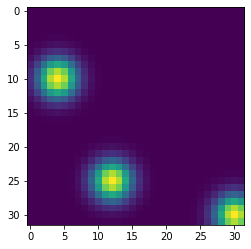

In [10]:
def generate_keypoints_heatmap(image_size, keypoints, sigma):
    """
    Generates heatmap with gaussian blobs for each keypoint, using the given sigma.
    Max operation is used to combine the heatpoints 
    Origin is topleft corner and u goes right, v down.

    image_size: (int,int) that specify (W,H) of the heatmap image
    keypoints: List((int,int)) with keypoints (u,v). 
    sigma: (float) std deviation of the blobs

    returns a np array of the heatmap
    """
    img = torch.zeros(image_size)
    sigma = torch.Tensor([sigma])
    for keypoint in keypoints:
        img = torch.maximum(img,gaussian_heatmap(image_size, keypoint, sigma)) # piecewise max of 2 Tensors
    return img

heatmap = generate_keypoints_heatmap((32,32), [(4,10), (12, 25), (30,30)], 2)
plt.imshow(heatmap)

In [11]:
from skimage.feature import peak_local_max
import numpy as np

def get_keypoints_from_heatmap(heatmap: np.ndarray, min_keypoint_pixel_distance):
    """ 
    Returns a list of (u,v) coordinates of the keypoints

    heatmap: a np 2D array
    min_keypoint_pixel_distance: minimum distance between 2 keypoints, so the area in which the keypoint has to be the local max is 2*min_distance + 1

    cf https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max
    """
    np_heatmap = heatmap.numpy()
    keypoints = peak_local_max(np_heatmap, min_distance = min_keypoint_pixel_distance)
    return keypoints[::,::-1] # convert to (u,v) aka (col,row) coord frame from (row,col) 

print (get_keypoints_from_heatmap(heatmap,1))


[[ 4 10]
 [12 25]
 [30 30]]


In [19]:
from skimage import io
from torchvision.transforms import ToTensor
import os 

class BoxKeypointsDataset(Dataset):
    """
    Create Custom Pytorch Dataset from the Box dataset
    cf https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """
    def __init__(self,json_file, image_dir):
        """
        json_file  path to json file with dataset
        image_dir: path to dir from where the relative image paths in the json are included
        transform: torch transforms to apply to the images before using them 
        """

        self.json_file = json_file
        self.image_dir = image_dir

        self.dataset  = None  # List of dicts with 'image_path', 'corner_keypoint' and 'flap_keypoints' keys for each item

    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        index = int(index)

        image_path = os.path.join(self.image_dir, self.dataset[index]['image_path'])
        image = io.imread(image_path)
        image = ToTensor(image)
        
        corner_keypoints = self.dataset[index]['corner_keypoints']
        flap_keypoints = self.dataset[index]['flap_keypoints']

        return image, corner_keypoints, flap_keypoints
    
        




In [20]:
class BoxKeypointsDataModule(pl.LightningDataModule):
    def __init__(self, dataset: BoxKeypointsDataset):
        self.dataset = dataset

        #TODO: split in test and train set
        self.train_dataset = dataset

    def prepare_data(self):
        # done in dataset class
        pass

    def train_dataloader(self):
        dataloader = DataLoader(self.train_dataset, self.batch_size, shuffle=True, num_workers=4)
        return dataloader

    def test_dataloader(self):
        pass

    

In [13]:
def imshow(img):
    """
    plot Tensor as image
    images are kept in the [0,1] range, although in theory [-1,1] should be used to whiten..
    """
    np_img = img.numpy()
    # bring (C,W,H) to (W,H,C) dims
    img = np.transpose(np_img, (1,2,0))
    plt.imshow(img)
    plt.show()
    

In [15]:
class KeypointDetector(pl.LightningModule):
    """ 
    Simple keypoint Detector using Gaussian Channels
    """
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.heatmap_sigma = 4 


        n_channels = 32
        n_channels_in = 3
        n_channels_out = 1 # number of keypoint classes 
        kernel_size = (3,3)
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=n_channels_in, out_channels=n_channels, kernel_size=kernel_size, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, dilation=2, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, dilation=4, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, dilation=8, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,dilation=16, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, dilation=2, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, dilation=4, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, dilation=8, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,dilation=16, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding='same'),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels_out, kernel_size=kernel_size, padding='same'),
            nn.Sigmoid()
        ).to(self.device)

    def forward(self,x):
        """
        x shape must be (N,C_in,H,W) with N batch size, and C_in number of incoming channels (3)
        return shape = (N, 1, H,W)
        """
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    def loss(self, predicted_heatmaps, heatmaps):
        # No focal loss as in CenterNet paper bc @Peter said it does not improve performance too much, so KISS and maybe add it later
        return torch.nn.functional.binary_cross_entropy(predicted_heatmaps, heatmaps, reduction='mean')
    
    def create_heatmap_batch(self, shape, keypoints):
        batch_heatmaps = [ generate_keypoints_heatmap(shape, keypoints[i],self.heatmap_sigma) for i in range(len(keypoints))]
        batch_heatmaps = np.stack(batch_heatmaps, axis=0)
        batch_heatmaps = torch.from_numpy(batch_heatmaps)

    def training_step(self, train_batch, batch_idx):
        imgs, corner_keypoints, flap_keypoints = train_batch

        # load here to device to keep mem consumption low, if possible one could also load entire dataset on GPU to speed up training..
        imgs = imgs.to(self.device)
        # create heatmaps JIT, is this desirable? 
        corner_heatmaps = self.create_heatmap_batch(img[0].shape[1:], corner_keypoints,self.heatmap_sigma).to(self.device)
        #flap_heatmaps = self.create_heatmap_batch(img[0].shape[1:], flap_keypoints,self.heatmap_sigma).to(self.device)


        predicted_heatmaps = self.foward(imgs)
        predicted_corner_heatmaps = predicted_heatmaps[:,0,:,:]

        corner_loss = self.loss(predicted_corner_heatmaps, corner_heatmaps)

        loss = corner_loss

        ## logging
        self.log('train_corner_loss', corner_loss)
        self.log('train_loss', loss)
        return loss 
        


torch.Size([1, 1, 32, 32])


In [16]:
model = KeypointDetector()
dummy_input = torch.rand((1,3,180,180))

output = model(dummy_input)
print(output.shape)
print(model)


torch.Size([1, 1, 180, 180])
KeypointDetector(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(4, 4))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(8, 8))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, dilation=(16, 16))
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), paddin

In [21]:
model = KeypointDetector()
box_dataset = BoxKeypointsDataset("json","image_dir")
datamodule = BoxKeypointsDataModule(box_dataset)

trainer = pl.Trainer(max_epochs = 1)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
trainer.fit(model, datamodule)